## Import

In [143]:
%matplotlib inline
import matplotlib
import random
import wget
import os
import torch
import datetime
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from enum import Enum
from sklearn.metrics import matthews_corrcoef
from torch.optim import AdamW
from torch.utils.data import random_split, TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, BertTokenizer, AutoModelForMaskedLM, BertForSequenceClassification, \
                         get_linear_schedule_with_warmup, AutoModel

print('Import is done.')

Import is done.


## Configuration

In [124]:
class Configurator:
    def __init__(self) -> None:
        self._params = {
            'random.seed': 42,
            
            'url.dataset.train': 'https://github.com/RussianNLP/RuCoLA/blob/main/data/in_domain_train.csv?raw=true',
            'url.dataset.test': 'https://github.com/RussianNLP/RuCoLA/blob/main/data/in_domain_dev.csv?raw=true',
            
            'path.dataset.train': './train_dataset.csv',
            'path.dataset.test': './test_dataset.csv',
            
            'name.train': 'TRAIN',
            'name.test': 'TEST',
  
            'dataframe.train.names': ['id', 'sentence', 'acceptable', 'error_type', 'detailed_source'],
            'dataframe.test.names': ['id', 'sentence', 'acceptable', 'error_type', 'detailed_source'],
            
            'bert.train-size': 0.9,
            'bert.batch-size': 32,
            'bert.optimizer.learning-rate': 2e-5,
            'bert.optimizer.eps': 1e-8,
#             'bert.train.epochs': 2
            'bert.train.epochs': 1,
#             'bert.pretrain.path': 'ai-forever/ruBert-base',
            'bert.pretrain.path': 'DeepPavlov/rubert-base-cased'
        }
    
    def __call__(self, *args, **kwargs):
        if len(args) == 0 or args[0] not in self._params:
            return None
        return self._params[args[0]]
    
    def check(self, *args):
        result = True
        absence_params = set()
        for arg in args:
            if isinstance(arg, str) and arg not in self._params:
                result = False
                absence_params.add(arg)
        message = 'Absence params: ' + ', '.join(absence_params)
        assert result, message
        
        
conf = Configurator()

print('Configuration block is done.')

Configuration block is done.


## Conditions

In [125]:
class CList(Enum):
    SET_RANDOM_SEED = 0
    DEVICE_DEFINED = 1
    DATASET_DOWNLOADED = 2
    DATASET_LOADED = 3
    DATASET_PREPARED = 4
    TOKENIZERS_MODELS_CREATED = 5
    BERT_SCHEDULER_CREATED = 6
    BERT_TRAINED = 7
    BERT_TESTED = 8

class Conditions:    
    def __init__(self) -> None:
        self._conditions = {}
        
    def set(self, message, *conditions):
        for condition in conditions:
            self._conditions[condition] = True
        print(message)
    
    def check(self, *conditions):
        result = True
        absence = set()
        for condition in conditions:
            if condition not in self._conditions:
                result = False
                absence.add(condition.name)
        fail_message = 'Absence conditions: ' + ', '.join(absence)
        assert result, fail_message

conds = Conditions()

print('Conditions block is done.')

Conditions block is done.


## Set random seed

In [126]:
conf.check('random.seed')

random.seed(conf('random.seed'))
np.random.seed(conf('random.seed'))
torch.manual_seed(conf('random.seed'))
torch.cuda.manual_seed(conf('random.seed'))

conds.set('Random seed is set.', CList.SET_RANDOM_SEED)

Random seed is set.


## Define device

In [127]:
conds.check(CList.SET_RANDOM_SEED)

if torch.cuda.is_available():
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print(f'We will use the GPU: {torch.cuda.get_device_name(0)}')
    device = torch.device('cuda')
else:
    print('No GPU available, using the GPU instead.')
    device = torch.device('cpu')
    
conds.set("Device is defined", CList.DEVICE_DEFINED)

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3080 Laptop GPU
Device is defined


## Models & tokenizers & optimizers creation

In [128]:
conf.check('bert.optimizer.learning-rate', 'bert.optimizer.eps', 'bert.pretrain.path')
conds.check(CList.DEVICE_DEFINED)

bert_tokenizer = BertTokenizer.from_pretrained(conf('bert.pretrain.path'))
bert_model = BertForSequenceClassification.from_pretrained(
    conf('bert.pretrain.path'),
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

bert_optimizer = AdamW(bert_model.parameters(), lr=conf('bert.optimizer.learning-rate'), eps=conf('bert.optimizer.eps'))

conds.set('Models & tokenizers creation is done.', CList.TOKENIZERS_MODELS_CREATED)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

Models & tokenizers creation is done.


## Downloading datasets on disk

In [129]:
# optimize checking  !!!
conf.check(
    'url.dataset.train',
    'path.dataset.train',
    'name.train',
    'url.dataset.test',
    'path.dataset.test',
    'name.test'
);
conds.check(CList.TOKENIZERS_MODELS_CREATED)

def load_dataset(url: str, path: str, name: str):
    if os.path.exists(path):
        print('Dataset "' + name + '" is already downloaded.')
    else:
        wget.download(url, path)
        print(' Dataset "' + name + '" is downloaded.')
        
load_dataset(conf('url.dataset.train'), conf('path.dataset.train'), conf('name.train'))
load_dataset(conf('url.dataset.test'), conf('path.dataset.test'), conf('name.test'))
conds.set('Datasets downloading is done', CList.DATASET_DOWNLOADED)

Dataset "TRAIN" is already downloaded.
Dataset "TEST" is already downloaded.
Datasets downloading is done


## Loading datasets from disk

In [130]:
conf.check(
    'path.dataset.train',
    'path.dataset.test',
    'dataframe.train.names',
    'dataframe.test.names'
)
conds.check(CList.DATASET_DOWNLOADED)

train_dataframe = pd.read_csv(
    conf('path.dataset.train'),
    names=conf('dataframe.train.names'),
    skiprows=1,
    usecols=conf('dataframe.train.usecols')
)

test_dataframe = pd.read_csv(
    conf('path.dataset.test'),
    names=conf('dataframe.test.names'),
    skiprows=1,
    usecols=conf('dataframe.test.usecols')
)
conds.set('Datasets are loaded from disk.', CList.DATASET_LOADED)

Datasets are loaded from disk.


## BERT datasets preparation, create dataloaders

In [131]:
conf.check('bert.batch-size', 'bert.batch-size', 'bert.batch-size')
conds.check(CList.DATASET_LOADED)

train_sentences = train_dataframe.sentence.values
train_acceptables = train_dataframe.acceptable.values
test_sentences = test_dataframe.sentence.values
test_acceptables = test_dataframe.acceptable.values


def define_raw_max_length_by_bert(sentences, raw_max_length):
    for sentence in sentences:
        input_ids = bert_tokenizer.encode(sentence, add_special_tokens=True)
        raw_max_length = max(raw_max_length, len(input_ids))    
    return raw_max_length


raw_max_length = define_raw_max_length_by_bert(train_sentences, 0)
raw_max_length = define_raw_max_length_by_bert(test_sentences, raw_max_length)


def define_max_length(raw_max_length, threshold):
    return threshold if threshold >= raw_max_length else define_max_length(raw_max_length, threshold * 2)


max_length = define_max_length(raw_max_length, 1)

def create_bert_dataset(sentences, acceptables, max_length):
    input_ids = []
    attention_masks = []
    for sentence in sentences:
        encoded_dict = bert_tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    acceptables = torch.tensor(acceptables)

    return TensorDataset(input_ids, attention_masks, acceptables)

train_val_dataset = create_bert_dataset(train_sentences, train_acceptables, max_length)
test_dataset = create_bert_dataset(test_sentences, test_acceptables, max_length);

train_val_dataset_size = len(train_val_dataset)
train_size = int(conf('bert.train-size') * train_val_dataset_size)
val_size = train_val_dataset_size - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=conf('bert.batch-size'))
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=conf('bert.batch-size'))
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=conf('bert.batch-size'))

conds.set('BERT datasets are prepared.', CList.DATASET_PREPARED)

BERT datasets are prepared.


## BERT scheduler creation

In [132]:
conf.check('bert.train.epochs')
conds.check(CList.DATASET_PREPARED)

bert_scheduler = get_linear_schedule_with_warmup(
    bert_optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * conf('bert.train.epochs')
)

conds.set('BERT scheduler is created.', CList.BERT_SCHEDULER_CREATED)

BERT scheduler is created.


## BERT finetune training


======= Epoch 1 / 1 =======

Training...
	Batch 40 of 222, elapsed: 0:00:08
	Batch 80 of 222, elapsed: 0:00:16
	Batch 120 of 222, elapsed: 0:00:24
	Batch 160 of 222, elapsed: 0:00:33
	Batch 200 of 222, elapsed: 0:00:41
	Batch 222 of 222, elapsed: 0:00:45

	Average training loss: 0.5613319622772234
	Training epcoh took: 0:00:45

Running validation...

	Accuracy: 0.7311842105263158
	Validation loss: 0.5656290757656097
	Validation took: 0:00:01

Trainig complete!
Total trainig took: 0:00:47


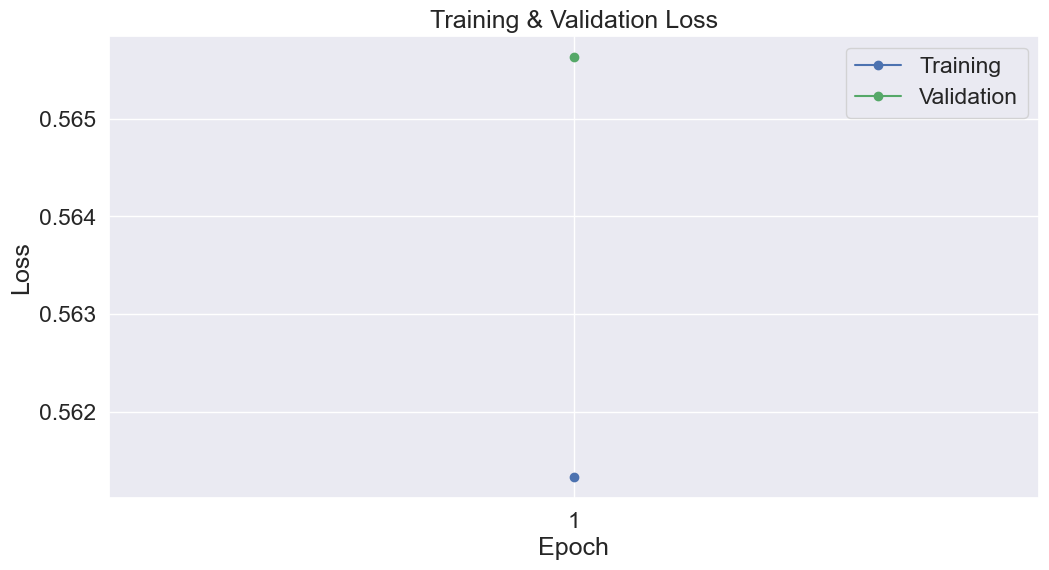

BERT is trained.


In [133]:
conf.check('bert.train.epochs')
conds.check(CList.BERT_SCHEDULER_CREATED)

# < !!! to utils block & rename
def flat_accuracy_bert(predictions, labels):
    predictions_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(predictions_flat == labels_flat) / len(labels_flat)

# < !!! to utils block & rename
def format_time_bert(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

# < !!!
def log_step(step: int, offset: int, length: int, t0):
    if ((step + 1) % offset == 0 and not step == 0) or (step == length - 1):
        elapsed = format_time_bert(time.time() - t0)
        print(f'\tBatch {step+1} of {len(train_dataloader)}, elapsed: {elapsed}')    

# < !!!
def extract_from_batch(batch, device) -> tuple:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    return b_input_ids, b_input_mask, b_labels

bert_model.cuda()

training_stats = []
total_t0 = time.time()
train_dataloader_length = len(train_dataloader)
val_dataloader_length = len(val_dataloader)

epochs = conf('bert.train.epochs')
for epoch_i in range(0, epochs):
    print(f'\n======= Epoch {epoch_i + 1} / {epochs} =======\n')
    print('Training...')
    
    t0 = time.time()
    total_train_loss = 0
    bert_model.train()
        
    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_labels = extract_from_batch(batch, device)
        bert_model.zero_grad()
        
        res = bert_model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels
        )
        loss = res['loss']

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

        bert_optimizer.step()
        bert_scheduler.step()
        
        log_step(step, 40, train_dataloader_length, t0)
    
    avg_train_loss = total_train_loss / train_dataloader_length
    train_time = format_time_bert(time.time() - t0)
    print(f'\n\tAverage training loss: {avg_train_loss}\n\tTraining epcoh took: {train_time}')

    print('\nRunning validation...')
    t0 = time.time()
    total_eval_accuracy = 0
    total_eval_loss = 0
    
    bert_model.eval()
    
    for batch in val_dataloader:
        b_input_ids, b_input_mask, b_labels = extract_from_batch(batch, device)
        
        with torch.no_grad():
            res = bert_model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels
            )
        loss = res['loss']
        logits = res['logits']
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy_bert(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / val_dataloader_length
    avg_val_loss = total_eval_loss / val_dataloader_length
    val_time = format_time_bert(time.time() - t0)
    print(f'\n\tAccuracy: {avg_val_accuracy}')
    print(f'\tValidation loss: {avg_val_loss}')
    print(f'\tValidation took: {val_time}')
    
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': train_time,
            'Validation Time': val_time
        }
    )

print('\nTrainig complete!')
print(f'Total trainig took: {format_time_bert(time.time() - total_t0)}')

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12, 6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([i + 1 for i in range(epochs)])

plt.show()

conds.set('BERT is trained.', CList.BERT_TRAINED)

## BERT test & MCC calculation

In [145]:
conds.check(CList.BERT_SCHEDULER_CREATED)

# < !!!
def extract_from_batch(batch, device) -> tuple:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    return b_input_ids, b_input_mask, b_labels

bert_model.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
    b_input_ids, b_input_mask, b_labels = extract_from_batch(batch, device)

    with torch.no_grad():
        outputs = bert_model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask
        )
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

print('Positive samples: %d of %d (%.2f%%)' % (test_dataframe.acceptable.sum(), len(test_dataframe.acceptable), (test_dataframe.acceptable.sum() / len(test_dataframe.acceptable) * 100.0)))

matthews_set = []
for i in range(len(true_labels)):
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
    matthews_set.append(matthews)

flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('Total MCC: %.3f' % mcc)

conds.set('BERT is tested.', CList.BERT_TESTED)

Positive samples: 733 of 983 (74.57%)
Total MCC: 0.274
BERT is tested.
